## Sending data to Kafka server

This notebook uses the [Python client for the Apache Kafka distributed stream processing system](http://kafka-python.readthedocs.io/en/master/index.html) to send messages to a Kafka cluster. 

In this example, the messages are data generated from a linear model with $n$ input variables, i.e., 

$$
y =x^T \beta +w
$$
with $x, \beta \in \mathbb{R}^n$, and $y, w \in \mathbb{R}$. $w$ is Gaussian noise.

Messages are sent every $interval$ seconds. They are list of size (n+2) where:
* First element is the counter 
* Second element is $y$ 
* Third to last elements are $x$ values (size $n$)


In [15]:
from kafka import KafkaProducer
import time
import numpy as np
import pandas as pd

In [16]:
#Takes about one minute to load
data=pd.read_csv("../../data/data.conv.txt.gz",header=None,sep=" ")
data.columns=["Date","Hour","Sensor","Value","Voltage"]
data=data.sort_values(['Date','Hour']).reset_index(drop=True)

data['datetime']=pd.to_datetime(data.Date+' '+data.Hour)
data['relative_datetime']=data['datetime']-data['datetime'][0]
data['seconds']=data['relative_datetime'].dt.total_seconds()

sensorId_type=data.Sensor.str.split("-",expand=True)
sensorId_type.columns=['SensorId','Type']
data['SensorId']=sensorId_type['SensorId'].astype(int)
data['Type']=sensorId_type['Type'].astype(int)

In [17]:
#Drop features not needed for the simulation
data=data.drop(['datetime','relative_datetime','Sensor','Date','Hour','Voltage'],axis=1)

In [18]:
data[-5:]

,Value,seconds,SensorId,Type
6939463,0.04022,3150123.390,56,2
6939464,35.85300,3150123.706,56,1
6939465,37.72000,3150152.840,56,2
6939466,36.43960,3150153.033,56,1
6939467,23.53600,3150153.360,56,0


In [34]:
temp=data[(data.Type==0)]
temp=temp.reset_index(drop=True)

In [35]:
# Sensors to predict
sensors_to_predict = [1, 24]
temp = temp[temp.SensorId.isin(sensors_to_predict)]
print(temp[:10])

       Value  seconds  SensorId  Type
64   18.1362   53.492        24     0
79   19.2436   79.124         1     0
81   18.1166   79.230        24     0
114  18.1264  108.864        24     0
146  18.1362  138.638        24     0
188  19.2240  169.155         1     0
224  19.2142  200.931         1     0
247  18.1460  229.040        24     0
305  19.1848  264.276         1     0
321  18.1264  290.305        24     0


In [36]:
day_to_predict = 1 # must be at least 1

temp_train = temp[temp.seconds < day_to_predict*86400]
temp_test = temp[(temp.seconds >= day_to_predict*86400) & (temp.seconds < (day_to_predict+1)*86400)]
temp_tot = temp[temp.seconds < (day_to_predict+1)*86400]

temp_tot.iloc[0]

Value       18.1362
seconds     53.4920
SensorId    24.0000
Type         0.0000
Name: 64, dtype: float64

In [22]:
def rollup(temp, interval, day_begin=0):
    # roll up data according to a time interval
    first_temp = day_begin*86400
    last_temp = temp.iloc[-1].seconds
    time_bins = int((last_temp-first_temp)/interval) + 1
    temp_sync = np.zeros((time_bins, 5)) # Value, bin, SensorID, Type, number of elem in bin

    for i in range(len(temp)):
        data = temp.iloc[i]
        bin = int((data.seconds-first_temp)/interval)
        n = temp_sync[bin][-1] + 1
        new_value = (temp_sync[bin][0] * (n-1) + data.Value)/n # running avg
        temp_sync[bin][0] = new_value
        temp_sync[bin][1] = bin
        temp_sync[bin][2] = int(data.SensorId)
        temp_sync[bin][3] = int(data.Type)
        temp_sync[bin][4] = n
    return temp_sync


def delta_max(temp):
    # evaluate the maximum time interval between two data
    maxT = 0
    for i in range(1,len(temp)):
        time_now = temp.iloc[i].seconds
        time_before = temp.iloc[i-1].seconds
        delta = time_now - time_before
        if delta > maxT:
            maxT = delta
    return maxT


def interpolate(temp_sync, nbin_left, nbin_right):
    # interpolate missing data in rolled up data using the data of K neighbours
    # rolled up data referes to the output of rollup function
    # nbin_left: number of past data used for interpolation
    # nbin_right: number of futur data used for interpolation
    for bin in range(len(temp_sync)):
        # if no value provided
        left_range = max(0, bin-nbin_left)
        right_range = min(len(temp_sync), bin+nbin_right)
        if temp_sync[bin][-1] == 0:
            bins = []
            vals = []
            sensorId = 0
            for n in range(int(left_range), int(right_range)):
                if temp_sync[n][-1] != 0:
                    bins.append(n)
                    vals.append(temp_sync[n][0])
                    sensorId = int(temp_sync[n][2])
            val_interp = np.interp(bin, bins, vals)
            temp_sync[bin][0] = val_interp
            temp_sync[bin][1] = bin
            temp_sync[bin][2] = sensorId
            temp_sync[bin][3] = 0
            temp_sync[bin][4] = 1
    return temp_sync

In [28]:
delta_max_train = delta_max(temp_train)
print(delta_max_train)

88.832


In [30]:
# Create a cleaned temperature vector:
# we want one data every interval, this is not always the case in the raw data
interval = 30 # seconds
temp_tot_sync = [0] * len(sensors_to_predict)
for i in range(len(sensors_to_predict)):
    temp_tot_i = temp_tot[temp_tot.SensorId == sensors_to_predict[i]]
    temp_tot_sync[i] = rollup(temp_tot_i, interval, day_begin=0)

    print('Number of intervals of %ds for sensor %d: %d' %(interval, sensors_to_predict[i], len(temp_tot_sync[i])))

Number of intervals of 30s for sensor 1: 2880
Number of intervals of 30s for sensor 24: 2879


In [31]:
print('Sensor 1:')
print(temp_tot_sync[0][:5])
print('Sensor 24:')
print(temp_tot_sync[1][:5])

Sensor 1:
[[  0.       0.       0.       0.       0.    ]
 [  0.       0.       0.       0.       0.    ]
 [  0.       0.       0.       0.       0.    ]
 [ 18.8467   3.       1.       0.       2.    ]
 [  0.       0.       0.       0.       0.    ]]
Sensor 24:
[[  1.81166000e+01   0.00000000e+00   2.40000000e+01   0.00000000e+00
    2.00000000e+00]
 [  1.81362000e+01  -2.87800000e+03   2.40000000e+01   0.00000000e+00
    1.00000000e+00]
 [  1.81166000e+01  -2.87700000e+03   2.40000000e+01   0.00000000e+00
    1.00000000e+00]
 [  1.81264000e+01  -2.87600000e+03   2.40000000e+01   0.00000000e+00
    1.00000000e+00]
 [  1.81362000e+01  -2.87500000e+03   2.40000000e+01   0.00000000e+00
    1.00000000e+00]]


In [32]:
K = 6 # interpolation memory, choose according to interval (and eventually maxT)
for i in range(len(sensors_to_predict)):
    temp_tot_sync[i] = interpolate(temp_tot_sync[i], K, K)
    
print('Sensor 1:')
print(temp_tot_sync[0][:5])
print('Sensor 24:')
print(temp_tot_sync[1][:5])

Sensor 1:
[[ 18.8467    0.        1.        0.        1.     ]
 [ 18.8467    1.        1.        0.        1.     ]
 [ 18.8467    2.        1.        0.        1.     ]
 [ 18.8467    3.        1.        0.        2.     ]
 [ 18.64335   4.        1.        0.        1.     ]]
Sensor 24:
[[  1.81166000e+01   0.00000000e+00   2.40000000e+01   0.00000000e+00
    2.00000000e+00]
 [  1.81362000e+01  -2.87800000e+03   2.40000000e+01   0.00000000e+00
    1.00000000e+00]
 [  1.81166000e+01  -2.87700000e+03   2.40000000e+01   0.00000000e+00
    1.00000000e+00]
 [  1.81264000e+01  -2.87600000e+03   2.40000000e+01   0.00000000e+00
    1.00000000e+00]
 [  1.81362000e+01  -2.87500000e+03   2.40000000e+01   0.00000000e+00
    1.00000000e+00]]


In [26]:
producer = KafkaProducer(bootstrap_servers='kafka1:19092,kafka2:29092,kafka3:39092')

In [33]:
# Feeding training data:
interval = 1 # interval for each batch

n = 1 # number of previous day to analyze
m = 10 # number of short-term parameters 
N = m + n*m # total number of parameters

step = int(86400/interval) # number of bins in one day
start_t = int(n*step + m/2) # (n+1)th day
end_t = start_t + day_to_predict*step


for t in range(start_t, end_t):
    tic = time.time()
    for i in range(len(sensors_to_predict)):
        xm = temp_tot_sync[i][t-1:t-1-m:-1,0] # m last short-term temperature
        xn = temp_tot_sync[i][int(t-step+m/2):int(t-step-m/2):-1,0] # m temperature of last day
        #xn = temp_tot_sync[t-step:t-(n+1)*step:-step, 0] # n last long-term temperature
        x = np.hstack((xm,xn))
        y = temp_tot_sync[i][t, 0] # current temperature
        key = str(sensors_to_predict[i])
        message = np.array2string(np.append([t,y],x),separator=",")
        print(t, len(x), y)
        producer.send('RLSTrain', key=key.encode(), value=message.encode())
    toc = time.time() - tic
    time.sleep(interval - toc)
    

IndexError: index 86405 is out of bounds for axis 0 with size 2880

In [41]:
# use model on testing data


n = 3
m = 10 
N = m + n
step = int(86400/interval)
start_t = 8*step
end_t = len(temp_tot_sync)

theta1 = np.load('theta1_30s_LSTM.npy')
theta2 = np.load('theta2_30s_LSTM.npy')

y_hat1 = np.zeros((end_t-start_t, 1))
y_hat2 = np.zeros((end_t-start_t, 1))
y = np.zeros((end_t-start_t, 1))

xm_init = temp_tot_sync[start_t-1:start_t-1-m:-1, 0]
xm1 = xm_init
xm2 = xm_init

for t in range(start_t, end_t):
    y[t-start_t] = temp_tot_sync[t, 0]
    xm1 = xm1[0:m] # m last short-term temperature
    xm2 = xm2[0:m:] # m last short-term temperature
    xn = temp_tot_sync[t-step:t-(n+1)*step:-step, 0]
    x1 = np.hstack((xm1, xn))
    x2 = np.hstack((xm2, xn))
    y_hat1[t-start_t] = x1.dot(theta1)
    y_hat2[t-start_t] = x2.dot(theta2)
    xm1 = np.insert(xm1, 0, y_hat1[t-start_t])
    xm2 = np.insert(xm2, 0, y_hat2[t-start_t])

mse1 = np.mean(np.square(y_hat1 - y))
mse2 = np.mean(np.square(y_hat2 - y))

print('MSE mod1', mse1)
print('MSE mod2', mse2)


MSE mod1 7.37646804487
MSE mod2 14.8985813146


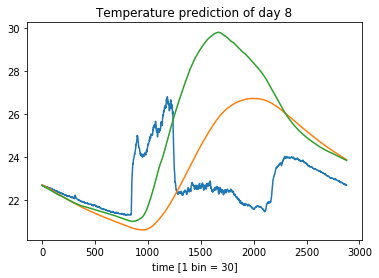

In [42]:
import matplotlib.pyplot as plt

t = np.arange(end_t - start_t)
fig1, ax1 = plt.subplots()
ax1.plot(t, y,)
ax1.set_title("Temperature prediction of day 8")
ax1.set_xlabel("time [1 bin = 30]")

ax1.plot(t, y_hat1)
ax1.plot(t, y_hat2)

plt.show()

In [3]:
i=0 #Initialise counter

n=10   # number of inputs

beta=np.zeros(n) ## first and last parameters are 1, others are zeros
beta[1]=1   
beta[-1]=1
beta.shape=(n,1)


#Loop for sending messages to Kafka with the topic dataLinearModel

while True:
    x=np.random.rand(1,n)[0]
    y=float(x.dot(beta))+0.1*np.random.rand(1)[0] ## y =x^T beta +w
    message=np.array2string(np.append([i,y],x),separator=",") 
    print(message)
    producer.send('dataLinearModel', message.encode())
    i=i+1
    time.sleep(1)

[ 0.        , 0.95772618, 0.67060354, 0.24211019, 0.17263733, 0.79885759,
  0.48056794, 0.98570543, 0.1627009 , 0.58327203, 0.78245165, 0.68484422]
[ 1.        , 0.65940146, 0.10026097, 0.05903539, 0.22909641, 0.32563214,
  0.6809396 , 0.60368021, 0.39138901, 0.26470633, 0.22869574, 0.52838563]
[ 2.        , 0.2607595 , 0.63829029, 0.13070341, 0.41263292, 0.54827117,
  0.04545682, 0.82817345, 0.67135199, 0.6920729 , 0.5594482 , 0.06165693]
[ 3.        , 0.95416609, 0.04906261, 0.12341107, 0.1070854 , 0.00331074,
  0.36320009, 0.2750774 , 0.57627341, 0.03799513, 0.60491055, 0.77024075]
[ 4.        , 1.7365181 , 0.92561066, 0.80130513, 0.36961445, 0.1497974 ,
  0.0540831 , 0.53595227, 0.70130951, 0.77182248, 0.23849375, 0.88075003]
[ 5.        , 1.21626752, 0.92572199, 0.6323603 , 0.83326384, 0.66514895,
  0.12938035, 0.99302658, 0.18598089, 0.5205909 , 0.48324244, 0.51460192]
[ 6.        , 0.86638299, 0.34990381, 0.54791102, 0.95241497, 0.70053108,
  0.23466649, 0.05525377, 0.45685857, 

[ 49.        ,  1.87313449,  0.62510852,  0.99297458,  0.14825713,
   0.33426   ,  0.96796691,  0.38571584,  0.14563271,  0.68380523,
   0.0765593 ,  0.87961825]
[ 50.        ,  0.85262817,  0.37115393,  0.79027126,  0.12221132,
   0.52871574,  0.18528548,  0.94761125,  0.67077707,  0.56343033,
   0.73476217,  0.05936989]
[ 51.        ,  1.53177351,  0.07192952,  0.8356925 ,  0.30456939,
   0.72036634,  0.60152491,  0.10571554,  0.53027396,  0.45361879,
   0.83916123,  0.68076368]
[ 52.        ,  0.54462778,  0.14085798,  0.13559422,  0.60213847,
   0.81927175,  0.40551726,  0.85744463,  0.39721184,  0.37305844,
   0.62073097,  0.33708896]
[  5.30000000e+01,  5.13963328e-01,  4.61748724e-01,  8.03057483e-03,
   3.47863740e-01,  4.84717892e-01,  2.52756041e-01,  7.83358292e-01,
   3.77895161e-01,  4.84854538e-01,  6.85209293e-01,  4.11295530e-01]
[  5.40000000e+01,  6.12267499e-01,  6.67857444e-01,  3.05062782e-03,
   8.59376114e-02,  2.48637159e-01,  7.93277057e-01,  4.25576201e-01,
  

[ 95.        ,  0.74256141,  0.7398143 ,  0.41258847,  0.82803955,
   0.15263898,  0.21054319,  0.42126611,  0.95203626,  0.10866459,
   0.51548958,  0.2905914 ]
[ 96.        ,  1.6696113 ,  0.98821607,  0.77123873,  0.67754367,
   0.43592821,  0.59097779,  0.20514365,  0.47219884,  0.28216909,
   0.4722199 ,  0.84666987]
[  9.70000000e+01,  4.85469055e-01,  6.60786921e-01,  2.33056135e-01,
   3.84478482e-01,  3.91092594e-02,  7.71698443e-01,  1.49730783e-01,
   2.20663948e-01,  7.69490805e-01,  6.71920478e-01,  1.69012289e-01]
[  9.80000000e+01,  1.36440073e+00,  1.98287538e-01,  3.30879059e-01,
   3.45809287e-01,  2.19958074e-01,  1.17128169e-01,  3.16137321e-01,
   7.34358494e-02,  1.84843309e-01,  5.56264035e-01,  9.55274517e-01]
[ 99.        ,  0.78407331,  0.36046046,  0.11776012,  0.67550267,
   0.79697578,  0.86638062,  0.19087129,  0.92443062,  0.22827448,
   0.6916496 ,  0.61069823]
[  1.00000000e+02,  1.05427074e+00,  2.23994077e-01,  2.22770007e-01,
   6.05842881e-01,  3.50

[ 137.        ,   1.56186691,   0.99772438,   0.73882414,   0.83229368,
    0.97996755,   0.77968494,   0.59510207,   0.34350337,   0.97291179,
    0.81865215,   0.78996039]
[  1.38000000e+02,  7.57344521e-01,  1.84121855e-03,  6.36404205e-01,
   8.86699789e-01,  9.81942860e-01,  3.03023302e-01,  4.47183902e-01,
   3.96710388e-01,  4.58223461e-01,  3.27556420e-01,  5.25036817e-02]
[  1.39000000e+02,  4.98088612e-01,  4.56647121e-01,  3.91178471e-01,
   1.91155223e-01,  1.05275659e-01,  2.12562195e-01,  3.22837434e-02,
   3.48470711e-01,  8.48370513e-01,  8.33550996e-01,  1.06781542e-01]
[  1.40000000e+02,  1.92212795e+00,  9.98387534e-01,  9.29409010e-01,
   6.17675495e-01,  6.81671152e-01,  2.64679670e-03,  2.80075024e-01,
   2.14498159e-02,  3.06135621e-01,  2.89395416e-01,  9.45287703e-01]
[  1.41000000e+02,  1.01230413e+00,  8.83800860e-01,  1.12125637e-01,
   7.70669374e-01,  1.91134872e-01,  8.47097335e-01,  5.38594024e-01,
   8.12080883e-01,  9.81414722e-01,  4.82912664e-01,  8.

[  1.78000000e+02,  1.82875554e+00,  6.85009784e-01,  9.62205070e-01,
   2.33256374e-02,  4.96188875e-01,  1.97638018e-01,  2.90406817e-01,
   7.27624227e-01,  4.20159381e-01,  7.42523967e-01,  7.83997807e-01]
[ 179.        ,   0.81341134,   0.54902644,   0.54997082,   0.704293  ,
    0.26121434,   0.73872776,   0.93690926,   0.64383099,   0.57384691,
    0.58668034,   0.23413189]
[  1.80000000e+02,  8.29697063e-01,  1.43703938e-01,  4.55591019e-01,
   9.31675835e-01,  5.55087904e-01,  7.06814862e-02,  6.72866323e-01,
   4.51644377e-01,  8.61214737e-01,  6.61000725e-01,  3.13623451e-01]
[ 181.        ,   0.92105487,   0.58577252,   0.55747535,   0.18783516,
    0.85034097,   0.82093457,   0.31894866,   0.50293326,   0.29657657,
    0.7351163 ,   0.31786376]
[  1.82000000e+02,  1.33262804e+00,  6.22761781e-01,  5.73983404e-01,
   3.46354217e-01,  5.98646880e-02,  4.59793514e-01,  9.72061587e-01,
   3.53080028e-01,  2.44058206e-01,  6.63953027e-01,  6.71737402e-01]
[  1.83000000e+02,  1.

[  2.19000000e+02,  1.52232424e+00,  2.94435038e-01,  5.17974212e-01,
   7.31628761e-01,  8.21507627e-03,  1.37696962e-01,  8.63706904e-01,
   2.15442942e-01,  4.10482911e-01,  5.34053617e-01,  9.30558840e-01]
[  2.20000000e+02,  8.93981474e-01,  6.78031313e-01,  4.98971550e-01,
   8.43419256e-01,  5.17246108e-02,  4.22236392e-03,  6.78908640e-01,
   4.08572853e-01,  2.80855511e-01,  8.77346136e-01,  3.73867061e-01]
[  2.21000000e+02,  1.02867200e+00,  1.37114082e-01,  3.74474724e-01,
   1.39824653e-01,  6.30201472e-01,  5.27514491e-02,  1.55546721e-01,
   3.53721296e-01,  7.49433302e-01,  6.22094467e-01,  5.58719219e-01]
[  2.22000000e+02,  1.41758510e+00,  6.78739913e-02,  4.29769880e-01,
   8.92242018e-01,  3.11614812e-02,  8.19866398e-01,  2.74089879e-01,
   3.93933653e-01,  7.73496980e-01,  3.51457460e-01,  9.67317940e-01]
[  2.23000000e+02,  1.21644562e+00,  7.67136369e-02,  8.74078533e-01,
   4.29372282e-01,  9.39368616e-01,  6.98425433e-01,  1.37329695e-01,
   9.00577398e-01,  

[  2.59000000e+02,  9.21804610e-01,  8.81025149e-01,  5.98463907e-02,
   1.25308028e-01,  7.97221413e-01,  5.26468124e-01,  5.97221169e-01,
   7.56180103e-01,  1.11127410e-01,  3.48878014e-01,  8.59532760e-01]
[  2.60000000e+02,  1.10892291e+00,  8.38355992e-01,  6.71369543e-01,
   8.43517127e-01,  6.92606033e-01,  3.25365642e-01,  1.19906416e-01,
   8.72460866e-01,  5.40435782e-01,  3.17458219e-01,  3.70615578e-01]
[  2.61000000e+02,  1.01373696e+00,  6.32787331e-02,  6.94373043e-01,
   7.28604506e-01,  7.59644155e-01,  2.43176596e-01,  6.98170100e-01,
   3.44032375e-01,  6.18245322e-01,  6.62289125e-01,  2.84650567e-01]
[  2.62000000e+02,  1.02990244e+00,  8.91542202e-01,  7.88932814e-01,
   1.52445833e-01,  4.89390947e-01,  8.37448099e-01,  3.13640470e-01,
   3.51954809e-01,  2.68490924e-01,  9.34797539e-01,  1.53344422e-01]
[  2.63000000e+02,  4.45038113e-01,  2.17660932e-01,  2.79841010e-01,
   1.08898440e-01,  8.66654122e-01,  6.07488436e-02,  5.10911444e-01,
   4.48856088e-01,  

[  2.99000000e+02,  1.06174472e+00,  3.03100166e-01,  1.47760876e-01,
   1.20282542e-01,  7.12303989e-01,  4.19277850e-01,  8.88124125e-01,
   8.63633713e-01,  6.92813643e-01,  2.55863371e-01,  8.88044353e-01]
[  3.00000000e+02,  7.96047208e-01,  8.12009039e-01,  2.47553377e-02,
   2.28740953e-01,  5.05999549e-01,  1.22879474e-01,  4.61715299e-01,
   4.44393358e-01,  9.29285284e-01,  1.26860686e-01,  7.14768131e-01]
[  3.01000000e+02,  1.75520054e+00,  8.53669787e-01,  7.44129656e-01,
   9.53786481e-01,  8.46402510e-01,  5.84660562e-01,  5.61710609e-01,
   2.11651644e-01,  2.45065390e-01,  4.07838127e-02,  9.87382149e-01]
[  3.02000000e+02,  8.45640460e-01,  5.34555820e-01,  5.54810256e-01,
   6.47091176e-01,  3.13049701e-01,  5.92483266e-01,  5.00259298e-01,
   8.89477920e-01,  5.73420687e-01,  8.58084435e-01,  2.58458725e-01]
[  3.03000000e+02,  1.76698678e+00,  6.86137209e-01,  8.77545669e-01,
   1.78887386e-01,  8.65480733e-01,  6.72477197e-01,  6.64758132e-01,
   3.52301421e-01,  

[  3.39000000e+02,  4.72944846e-01,  7.99646771e-01,  4.03747488e-01,
   1.20106340e-02,  5.08223959e-01,  1.74215977e-01,  3.60462012e-02,
   1.91199483e-01,  1.59315988e-01,  7.12895586e-01,  3.05595571e-02]
[  3.40000000e+02,  4.57426466e-01,  4.01728911e-01,  3.70136246e-01,
   5.95981926e-01,  1.91499102e-02,  9.17663702e-02,  1.58054703e-01,
   6.46276694e-01,  6.30856149e-01,  2.83864794e-01,  8.13679283e-02]


KeyboardInterrupt: 